In [69]:
import tensorflow_datasets as tfds
import tensorflow as tf
import io

In [70]:
# Load the IMDb movie reviews dataset with labels (as supervised pairs).
# 'data_dir' specifies the local dataset directory to avoid re-downloading.
imdb, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

In [71]:
# Print information about the dataset which will be useful for splitting train and test datasets in text and labels
print(info)

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_dir='/root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0',
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'text': Text(shape=(), dtype=string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInfo num_e

In [72]:
#split into train and test datasets
train_dataset, test_dataset = imdb['train'], imdb['test']

In [73]:
# Define key preprocessing parameters
VOCAB_SIZE = 10000     # Number of most frequent words to keep in the vocabulary
MAX_LENGTH = 120       # Fixed length for padded sequences
EMBEDDING_DIM = 12         # Embedding dimension size for the model
TRUNC_TYPE = 'post'    # Truncate sequences longer than MAX_LENGTH from the end
PADDING_TYPE = 'pre'   # Pad shorter sequences at the beginning

In [74]:
# Create a TextVectorization layer to convert text into integer sequences.
# This layer will learn the word index based on the training dataset vocabulary.
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens = VOCAB_SIZE)

# Get the string inputs and integer outputs of the training set
train_reviews = train_dataset.map(lambda review, label: review)
train_labels = train_dataset.map(lambda review, label: label)

# Get the string inputs and integer outputs of the test set
test_reviews = test_dataset.map(lambda review, label: review)
test_labels = test_dataset.map(lambda review, label: label)

# Build the vocabulary based on the training text.
vectorize_layer.adapt(train_reviews)

In [75]:
def padding_func(sequences):
    'generates padded sequences from tf.data.dataset'

    #put all elements in a signle ragged batch
    sequences = sequences.ragged_batch(batch_size=sequences.cardinality())

    #output a tensor from single batch
    sequences = sequences.get_single_element()

    #pad sequences
    padded_sequences = tf.keras.utils.pad_sequences(sequences.numpy(),
                                                    maxlen=MAX_LENGTH,
                                                    truncating=TRUNC_TYPE,
                                                    padding=PADDING_TYPE)

    #convert back to tf.dataset
    padded_sequences = tf.data.Dataset.from_tensor_slices(padded_sequences)

    return padded_sequences

In [76]:
# Perform text vectorization and sequence padding on the CPU.

# Convert raw text reviews into integer sequences using the TextVectorization layer
train_sequences = train_reviews.map(lambda text: vectorize_layer(text)).apply(padding_func)

# Apply the same preprocessing to the test dataset
test_sequences = test_reviews.map(lambda text: vectorize_layer(text)).apply(padding_func)


In [77]:
# View 2 training sequences
for example in train_sequences.take(2):
  print(example)
  print()

tf.Tensor(
[   0    0    0    0   11   14   34  412  384   18   90   28    1    8
   33 1322 3560   42  487    1  191   24   85  152   19   11  217  316
   28   65  240  214    8  489   54   65   85  112   96   22 5596   11
   93  642  743   11   18    7   34  394 9522  170 2464  408    2   88
 1216  137   66  144   51    2    1 7558   66  245   65 2870   16    1
 2860    1    1 1426 5050    3   40    1 1579   17 3560   14  158   19
    4 1216  891 8040    8    4   18   12   14 4059    5   99  146 1241
   10  237  704   12   48   24   93   39   11 7339  152   39 1322    1
   50  398   10   96 1155  851  141    9], shape=(120,), dtype=int32)

tf.Tensor(
[   0    0    0    0    0    0    0    0   10   26   75  617    6  776
 2355  299   95   19   11    7  604  662    6    4 2129    5  180  571
   63 1403  107 2410    3 3905   21    2    1    3  252   41 4781    4
  169  186   21   11 4259   10 1507 2355   80    2   20   14 1973    2
  114  943   14 1740 1300  594    3  356  180  446    6

In [78]:
# Combine the preprocessed text sequences and corresponding labels
# into unified (input, label) pairs for model training and evaluation.
train_dataset_vectorized = tf.data.Dataset.zip((train_sequences, train_labels))
test_dataset_vectorized  = tf.data.Dataset.zip((test_sequences, test_labels))

In [79]:
# View 2 training sequences and its labels
for example in train_dataset_vectorized.take(2):
  print(example)
  print()

(<tf.Tensor: shape=(120,), dtype=int32, numpy=
array([   0,    0,    0,    0,   11,   14,   34,  412,  384,   18,   90,
         28,    1,    8,   33, 1322, 3560,   42,  487,    1,  191,   24,
         85,  152,   19,   11,  217,  316,   28,   65,  240,  214,    8,
        489,   54,   65,   85,  112,   96,   22, 5596,   11,   93,  642,
        743,   11,   18,    7,   34,  394, 9522,  170, 2464,  408,    2,
         88, 1216,  137,   66,  144,   51,    2,    1, 7558,   66,  245,
         65, 2870,   16,    1, 2860,    1,    1, 1426, 5050,    3,   40,
          1, 1579,   17, 3560,   14,  158,   19,    4, 1216,  891, 8040,
          8,    4,   18,   12,   14, 4059,    5,   99,  146, 1241,   10,
        237,  704,   12,   48,   24,   93,   39,   11, 7339,  152,   39,
       1322,    1,   50,  398,   10,   96, 1155,  851,  141,    9],
      dtype=int32)>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)

(<tf.Tensor: shape=(120,), dtype=int32, numpy=
array([   0,    0,    0,    0,    0,    0

In [80]:
# Define dataset optimization constants
SHUFFLE_BUFFER_SIZE = 1000         # Number of elements to load into memory for random shuffling
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE  # Automatically tune prefetch buffer size for performance
BATCH_SIZE = 32                    # Number of samples per batch during training

# Optimize the training dataset for performance
# - cache(): keep data in memory after first pass for faster subsequent epochs
# - shuffle(): randomize data order to prevent bias during training
# - batch(): group samples into fixed-size batches for efficient computation
# - prefetch(): prepare the next batch while the current one is being processed
train_dataset_final = (train_dataset_vectorized
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .batch(BATCH_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                       )

# Optimize the test dataset (no shuffle needed)
# - cache(): speeds up evaluation by storing preprocessed data
# - batch(): evaluate multiple samples at once
# - prefetch(): overlap data loading with model evaluation
test_dataset_final = (test_dataset_vectorized
                      .cache()
                      .batch(BATCH_SIZE)
                      .prefetch(PREFETCH_BUFFER_SIZE)
                      )

In [92]:
# Create a sequential neural network for binary sentiment analysis.
# Input: padded sequences of word indices
# Output: probability (0 = negative, 1 = positive)
model = tf.keras.Sequential([
    # Input layer: expects reviews of fixed length (MAX_LENGTH)
    tf.keras.Input(shape=(MAX_LENGTH,)),

    # Embedding layer: converts word indices into dense vector representations.
    # Learns word embeddings during training (VOCAB_SIZE words × EMBEDDING_DIM dimensions)
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM),

    tf.keras.layers.GlobalAveragePooling1D(),

    # Hidden dense layer with ReLU activation for non-linear feature learning
    tf.keras.layers.Dense(16, activation='relu'),

    # Dropout layer to avoid overfitting
    tf.keras.layers.Dropout(0.5),

    # Output layer with sigmoid activation to produce a probability (0–1)
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Configure the learning process:
# - Loss: binary crossentropy (for 2-class sentiment)
# - Optimizer: Adam (adaptive learning rate)
# - Metric: accuracy (percentage of correct predictions)
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 120, 12)        │       120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_5      │ (None, 12)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,225 (469.63 KB)

 Trainable params: 120,225 (469.63 KB)

 Non-trainable params: 0 (0.00 B)

In [93]:
# Number of epochs (full passes through the training dataset)
NUM_EPOCHS = 3

history = model.fit(
    train_dataset_final,
    epochs=NUM_EPOCHS,
    validation_data=test_dataset_final
)

#we can run for more epochs but it will reduce validation accuracy and cause overfitting which can be adressed by more data, embedding size or model architecture

Epoch 1/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.6320 - loss: 0.6525 - val_accuracy: 0.7996 - val_loss: 0.4506
Epoch 2/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8230 - loss: 0.4228 - val_accuracy: 0.8264 - val_loss: 0.3872
Epoch 3/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8627 - loss: 0.3477 - val_accuracy: 0.8293 - val_loss: 0.3782


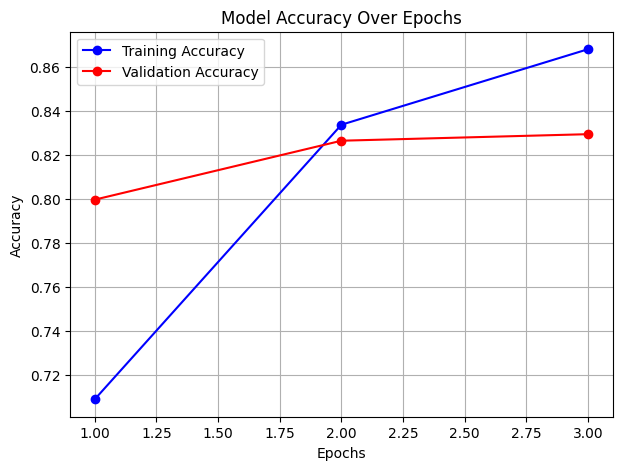

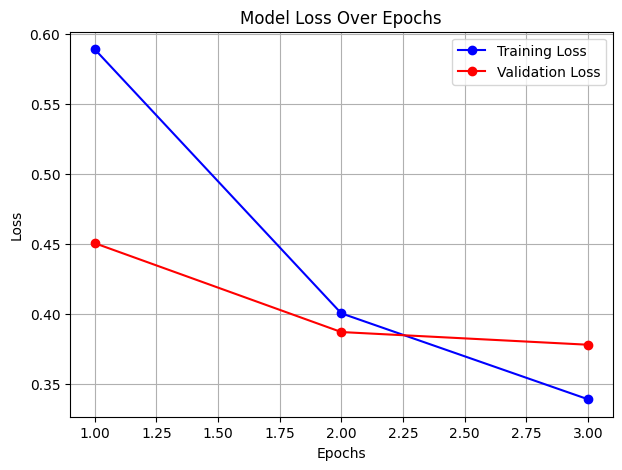

In [94]:
# =============================================================
# 📊 Visualize Training and Validation Performance
# =============================================================

import matplotlib.pyplot as plt

# Extract metrics from training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot Accuracy
plt.figure(figsize=(7, 5))
plt.plot(epochs, acc, 'b-o', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-o', label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(7, 5))
plt.plot(epochs, loss, 'b-o', label='Training Loss')
plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [95]:
#Extract and Save Word Embeddings for Visualization
# Get the embedding layer (first layer of the model)
embedding_layer = model.layers[0]

# Retrieve the learned weight matrix from the embedding layer.
# Each row corresponds to one word's vector representation.
embedding_weights = embedding_layer.get_weights()[0]

# Print the shape of the embedding matrix
# Expected: (VOCAB_SIZE, EMBEDDING_DIM)
print("Embedding weights shape:", embedding_weights.shape)

Embedding weights shape: (10000, 12)


In [96]:
#Prepare TSV files for TensorFlow Embedding Projector
# - 'vecs.tsv' : contains the numeric word embeddings
# - 'meta.tsv' : contains the corresponding word tokens
# Upload both to https://projector.tensorflow.org/ to visualize.
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

# Retrieve the vocabulary learned by the TextVectorization layer
vocabulary = vectorize_layer.get_vocabulary()

# Loop over vocabulary indices (skip index 0 which is reserved for padding)
for word_num in range(1, len(vocabulary)):
    # Get the word token
    word_name = vocabulary[word_num]

    # Get the learned embedding vector for this word
    word_embedding = embedding_weights[word_num]

    # Write the word to the metadata file
    out_m.write(word_name + "\n")

    # Write the embedding values (tab-separated) to the vector file
    out_v.write('\t'.join([str(x) for x in word_embedding]) + "\n")

# Close files to ensure all data is written
out_v.close()
out_m.close()

print("✅ Embedding vectors and metadata saved as 'vecs.tsv' and 'meta.tsv'.")

✅ Embedding vectors and metadata saved as 'vecs.tsv' and 'meta.tsv'.


In [86]:
### 🔹 Save and Export the Learned Embeddings
#This section packages the trained embedding vectors (`vecs.tsv`) and their corresponding metadata (`meta.tsv`) into a single ZIP file.
#The output is stored in the `/output` directory, making it easy for anyone to reuse or visualize the embeddings (e.g., in the [TensorFlow Embedding Projector](https://projector.tensorflow.org)).

In [97]:
# =============================================================
# ✅ Save Trained Embeddings for Visualization or Analysis
# =============================================================

# Zip the embedding and metadata files
!zip -q embeddings.zip vecs.tsv meta.tsv

# Move the zip to a clearly visible output folder
!mkdir -p output
!mv embeddings.zip output/

# Verify saved files
!ls -lh output/

total 608K
-rw-r--r-- 1 root root 606K Nov  5 21:26 embeddings.zip
